## read folder

In [1]:
# read ecg

import os
import numpy as np
import pandas as pd
from typing import Tuple


FS_FALLBACK = 250.0                     # 若無時間欄，使用此取樣率

def load_ecg_csv(path: str) -> Tuple[pd.DataFrame, float, str]:
    """
    回傳: (df 只含 ['t_sec','wave'], fs_Hz, info)
    規則:
      - 若有 time/t/timestamp/sec/ms 等欄，嘗試判斷單位並換算成秒
      - 若沒有時間欄，用 FS_FALLBACK 與樣本索引建立時間
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f'File not found: {path}')
    df0 = pd.read_csv(path)
    if df0.empty:
        raise ValueError('Empty CSV.')

    cols = [c.lower().strip() for c in df0.columns]
    df0.columns = cols
    info = []

    # 嘗試找到時間欄
    t_col = next((c for c in ['t','time','timestamp','time_s','sec','seconds','ms','millisecond','milliseconds']
                  if c in df0.columns), None)

    if t_col is not None:
        t = pd.to_numeric(df0[t_col], errors='coerce').astype(float).values
        if len(t) < 2:
            raise ValueError('Time column too short to infer fs.')
        dt = np.diff(t)
        dt_med = float(np.nanmedian(dt))

        # 判斷秒或毫秒或索引
        if dt_med > 2:
            # 可能是樣本索引
            if (t % 1 == 0).mean() > 0.95:
                info.append('time looks like sample indices; using FS_FALLBACK')
                fs = float(FS_FALLBACK)
                t_sec = np.arange(len(t)) / fs
            else:
                info.append('time treated as seconds')
                t_sec = t
                fs = float(1.0 / np.nanmedian(np.diff(t_sec)))
        elif dt_med > 0.02:
            info.append('time treated as seconds')
            t_sec = t
            fs = float(1.0 / np.nanmedian(np.diff(t_sec)))
        else:
            # 可能是毫秒
            if dt_med < 0.002:
                info.append('time treated as seconds')
                t_sec = t
                fs = float(1.0 / np.nanmedian(np.diff(t_sec)))
            else:
                info.append('time treated as milliseconds; converted to seconds')
                t_sec = t 
                fs = float(1.0 / np.nanmedian(np.diff(t_sec)))

        # 選 ECG 欄
        ecg_col = next((c for c in ['ecg','ecg_mv','lead1','lead_i','v1','value','signal']
                        if c in df0.columns and c != t_col), None)
        if ecg_col is None:
            # 取第一個非時間欄
            rest = [c for c in df0.columns if c != t_col]
            if not rest:
                raise ValueError('No ECG column found.')
            ecg_col = rest[0]
        ecg = pd.to_numeric(df0[ecg_col], errors='coerce').astype(float).values
    else:
        info.append('no time column; using FS_FALLBACK and sample index')
        fs = float(FS_FALLBACK)
        first_col = df0.columns[0]
        ecg = pd.to_numeric(df0[first_col], errors='coerce').astype(float).values
        t_sec = np.arange(len(ecg)) / fs

    df = pd.DataFrame({'t_sec': t_sec, 'wave': ecg})
    return df, fs, '; '.join(info) if info else 'inferred automatically'

def normalize_ts(df: pd.DataFrame,
                 y_candidates=('ecg','mmv','mmwave','heartbeat','value','signal'),
                 dt: float|None=None,
                 amp_method: str='absmax',  # 'absmax' or 'minmax'
                 eps: float=1e-12) -> pd.DataFrame:
    # 找 y 欄
    cols_lower = {c.lower(): c for c in df.columns}
    ycol = next((cols_lower[c] for c in cols_lower if c in y_candidates), None)
    if ycol is None:
        raise KeyError(f"找不到訊號欄。可用候選：{y_candidates}；現有欄位：{list(df.columns)}")

    out = df.copy()

    # 確保 t_sec
    if 't_sec' not in out.columns:
        if dt is None:
            raise KeyError("缺少 't_sec' 且未提供 dt。請給 dt，例如 0.1")
        out.insert(0, 't_sec', np.arange(len(out))*dt)

    # 只保留 t_sec + y 並統一命名
    out = out[['t_sec', ycol]].rename(columns={ycol: 'wave'}).copy()

    # 幅度歸一到 [-1, 1]
    x = out['wave'].astype(float).to_numpy()
    if amp_method == 'absmax':
        # 保零點，適合雙極性（ECG）
        s = np.nanmax(np.abs(x))
        s = s if s > eps else 1.0
        x_norm = x / s
    elif amp_method == 'minmax':
        # 線性映射到 [-1, 1]
        x_min, x_max = np.nanmin(x), np.nanmax(x)
        if x_max - x_min < eps:
            x_norm = np.zeros_like(x)
        else:
            x_norm = 2.0 * (x - x_min) / (x_max - x_min) - 1.0
    else:
        raise ValueError("amp_method must be 'absmax' or 'minmax'.")

    out['wave'] = np.clip(x_norm, -1.0, 1.0)
    return out

def pltot_fixed(df, title='Signal', label='sig'):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,4))
    plt.plot(df['t_sec'], df['wave'], label=label)
    plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.title(title)
    plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

import numpy as np
import pandas as pd
from scipy.signal import find_peaks, butter, filtfilt
# 你已有的 load_ecg_csv, normalize_ts 可沿用

def _butter_bandpass(x, fs, low=5, high=15, order=2):
    nyq = fs/2.0
    b, a = butter(order, [low/nyq, high/nyq], btype="bandpass")
    return filtfilt(b, a, x)

def _moving_avg(x, fs, win_sec=0.10):
    w = max(3, int(round(win_sec*fs)))
    k = np.ones(w)/w
    return np.convolve(x, k, mode="same")

def _calc_bpm_core(sig, fs):
    """與 SCP 腳本一致：對 |sig| 找峰，門檻 mean+0.5*std，最短間距 0.4s"""
    sig_abs = np.abs(sig)
    thr = np.mean(sig_abs) + 0.5*np.std(sig_abs)
    peaks, _ = find_peaks(sig_abs, height=thr, distance=int(0.4*fs))
    if len(peaks) < 2: 
        return None
    rr = np.diff(peaks)/fs
    mean_rr = float(np.mean(rr))
    return 60.0/mean_rr if mean_rr > 0 else None

def ecg_hr_csv_like_scp(path, print_each=True):
    """讀 CSV -> 正規化 -> 三法 HR：原始、5-15Hz 濾波、0.10s 移動平均；回傳平均與各法"""
    df, fs, info = load_ecg_csv(path)
    df = normalize_ts(df, y_candidates=('ecg','heartbeat','value','signal','wave'), amp_method='absmax')
    x = df['wave'].to_numpy(float)

    bpm_raw    = _calc_bpm_core(x, fs)
    bpm_butter = _calc_bpm_core(_butter_bandpass(x, fs, 5, 15, 2), fs)
    bpm_smooth = _calc_bpm_core(_moving_avg(x, fs, 0.10), fs)

    vals = [b for b in (bpm_raw, bpm_butter, bpm_smooth) if b is not None]
    bpm_mean = float(np.mean(vals)) if vals else None

    if print_each:
        print(f"HR(raw)={bpm_raw:.1f} bpm"     if bpm_raw    is not None else "HR(raw)=NA")
        print(f"HR(butter 5-15Hz)={bpm_butter:.1f} bpm" if bpm_butter is not None else "HR(butter)=NA")
        print(f"HR(smooth 0.10s)={bpm_smooth:.1f} bpm"  if bpm_smooth is not None else "HR(smooth)=NA")
        print(f"HR(mean of available)={bpm_mean:.1f} bpm" if bpm_mean is not None else "HR(mean)=NA")

    return {
        "fs_Hz": float(fs),
        "hr_mean_bpm": bpm_mean,
        "hr_raw_bpm": bpm_raw,
        "hr_butter_5_15_bpm": bpm_butter,
        "hr_smooth_0p10s_bpm": bpm_smooth,
        "info": info
    }

# 用法：
# out = ecg_hr_csv_like_scp("/mnt/data/1_1lead.csv")
# print(out)

In [2]:
# -----------------------------
# MMV CSV loader (keeps the same I/O contract)
# -----------------------------
import shutil

def _load_mmv_csv(csv_path: str) -> pd.DataFrame:
    """
    Expect columns: t_sec, heartbeat.
    Will coerce names if close variants are present.
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"[error] mmv.csv not found: {csv_path}")
    df0 = pd.read_csv(csv_path)
    cols = {c.lower().strip(): c for c in df0.columns}

    # map possible variants
    tcol = None
    for k in ["t_sec", "t", "time", "time_s", "sec", "seconds"]:
        if k in cols: tcol = cols[k]; break
    ycol = None
    for k in ["heartbeat", "wave", "mmv", "value", "signal"]:
        if k in cols: ycol = cols[k]; break
    if tcol is None or ycol is None:
        raise ValueError(f"[error] require time and heartbeat columns. got: {list(df0.columns)}")

    df = pd.DataFrame({
        "t_sec": pd.to_numeric(df0[tcol], errors="coerce").astype(float),
        "heartbeat": pd.to_numeric(df0[ycol], errors="coerce").astype(float),
    }).dropna(subset=["t_sec", "heartbeat"]).reset_index(drop=True)
    return df

def process_vitals_folder(folder_path, outdir="outputs", fs_hint=10.0, show=False):
    """
    New behavior: read {folder_path}/mmv.csv.
    Output contract unchanged. Also write outdir/heart_rate_series.csv for compatibility.
    """
    mmv_path = os.path.join(folder_path, "mmv.csv")
    df = _load_mmv_csv(mmv_path)
    if df.empty:
        print("[error] mmv.csv is empty after parsing.")
        return None

    # infer fs from t_sec when possible; otherwise fall back
    t = df["t_sec"].to_numpy(float)
    fs = float(1.0 / np.nanmedian(np.diff(t))) if len(t) > 1 and np.isfinite(np.nanmedian(np.diff(t))) else float(fs_hint)

    os.makedirs(outdir, exist_ok=True)
    out_csv = os.path.join(outdir, "heart_rate_series.csv")

    # ensure exact columns as before
    df_out = df[["t_sec", "heartbeat"]].copy()
    df_out.to_csv(out_csv, index=False)

    if show:
        # quick preview plot
        plt.figure(figsize=(12, 3.5))
        plt.plot(df_out["t_sec"], df_out["heartbeat"], lw=0.9)
        plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.title("MMV heartbeat")
        plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    summary = {
        "samples": int(len(df_out)),
        "duration_s": float(df_out["t_sec"].iat[-1] - df_out["t_sec"].iat[0]) if len(df_out) > 1 else 0.0,
        "fs_Hz": float(fs),
        "est_hr_bpm": None,
        "csv": out_csv,
        "dataframe": df_out,
    }

    # also keep original file as the source of truth next to summary
    try:
        # if out_csv is not the same file, keep a copy already saved; else ignore
        if os.path.abspath(out_csv) != os.path.abspath(mmv_path):
            # optional: also drop a copy named mmv_original.csv
            shutil.copyfile(mmv_path, os.path.join(outdir, "mmv_original.csv"))
    except Exception:
        pass

    return summary

# unchanged
def transform_to_dataframe(summary):
    y = summary['dataframe']['heartbeat'].values
    dt = 0.1  # if you prefer using inferred fs: dt = 1.0/float(summary['fs_Hz'])
    t = np.arange(len(y)) * dt
    df = pd.DataFrame({'t_sec': t, 'mmv': y})
    return df

/Users/hsiangyu/Documents/radar-heartbeat-detection/實驗區/data/sample_5
HR(raw)=131.4 bpm
HR(butter 5-15Hz)=130.0 bpm
HR(smooth 0.10s)=131.2 bpm
HR(mean of available)=130.8 bpm


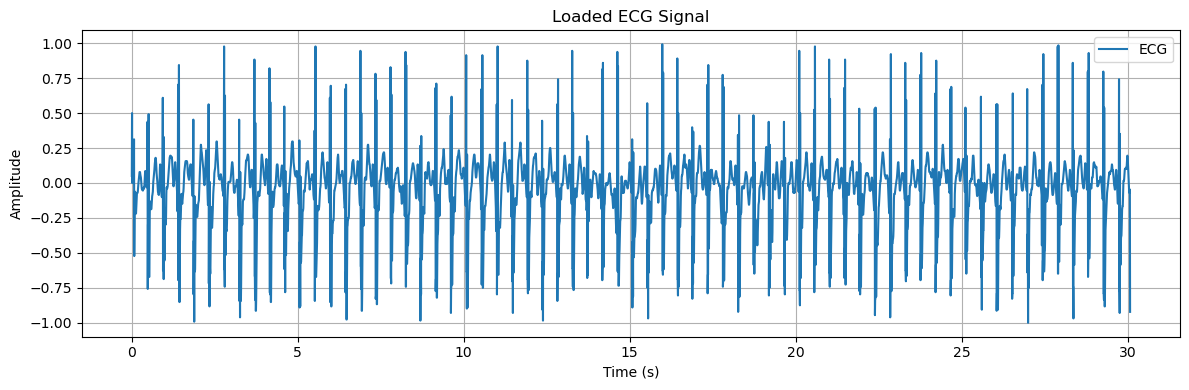

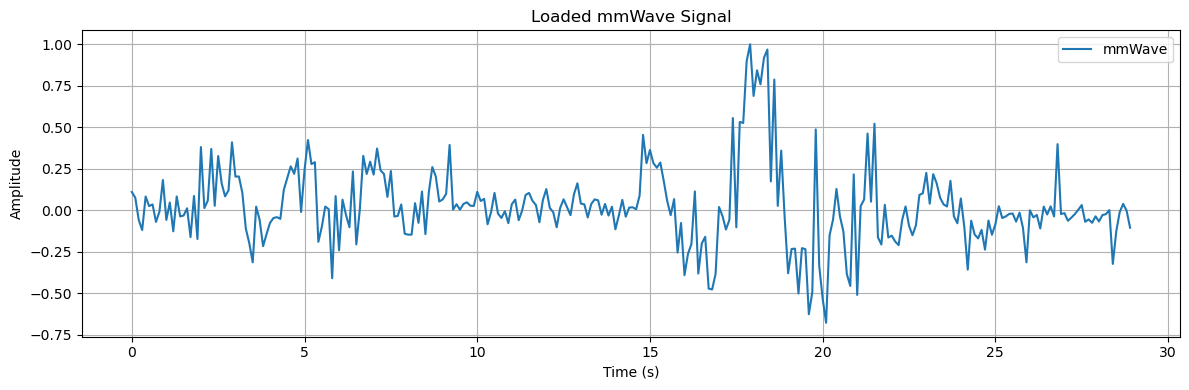

In [3]:
if __name__ == "__main__": #test
    import os
    cwd = os.getcwd()
    path=os.path.join(cwd, 'data','sample_5')
    print(path)
    df_ecg, fs_Hz, info = load_ecg_csv(path+'/1_1lead.csv') #read ecg
    res = ecg_hr_csv_like_scp(path+'/1_1lead.csv')
    res['hr_smooth_0p10s_bpm']


    summary = process_vitals_folder(path, outdir="outputs") # read mmv floder
    df_mmv= transform_to_dataframe(summary) 

    df_ecg_fixed = normalize_ts(df_ecg, y_candidates=('wave',), dt=None)
    pltot_fixed(df_ecg_fixed, title='Loaded ECG Signal', label='ECG')
    df_mmv_fixed = normalize_ts(df_mmv, y_candidates=('mmv','mmwave','heartbeat','value','signal'), dt=0.1)
    pltot_fixed(df_mmv_fixed, title='Loaded mmWave Signal', label='mmWave')



In [4]:
# input folder get sub folder (sample_n) 
import os
from pathlib import Path
import re

def get_sample_subdirs(root):
    root = Path(root)
    patt = re.compile(r"sample_\d+$")   # sample_1, sample_2, ...
    subs = [p for p in root.iterdir() if p.is_dir() and patt.fullmatch(p.name)]
    # sort by the numeric suffix
    subs.sort(key=lambda p: int(p.name.split("_")[1]))
    return subs

path= os.getcwd()+'/data'
# example
all_sample_wave=[] # [folder_name,ecg,mmw,rebuilding]
for p in get_sample_subdirs(path):
    print(p)
    # read ecg
    df_ecg, fs_Hz, info = load_ecg_csv(str(p)+'/1_1lead.csv') #read ecg
    res = ecg_hr_csv_like_scp(str(p)+'/1_1lead.csv')
    
    # read mmv
    summary = process_vitals_folder(p, outdir="outputs") # read mmv floder
    df_mmv= transform_to_dataframe(summary) 
    df_ecg_fixed = normalize_ts(df_ecg, y_candidates=('wave',), dt=None)
    df_mmv_fixed = normalize_ts(df_mmv, y_candidates=('mmv','mmwave','heartbeat','value','signal'), dt=0.1)
    all_sample_wave.append({'path':p,'ecg':df_ecg_fixed,'mmv':df_mmv_fixed,'summary':summary,'ecg_hr_res':res['hr_smooth_0p10s_bpm']})
    print(f'size of ecg: {len(df_ecg_fixed)}, size of mmv: {len(df_mmv_fixed)}, hr from ecg: {res["hr_smooth_0p10s_bpm"]}')


/Users/hsiangyu/Documents/radar-heartbeat-detection/實驗區/data/sample_0
HR(raw)=84.7 bpm
HR(butter 5-15Hz)=84.5 bpm
HR(smooth 0.10s)=81.1 bpm
HR(mean of available)=83.4 bpm
size of ecg: 4512, size of mmv: 384, hr from ecg: 81.13184604461216
/Users/hsiangyu/Documents/radar-heartbeat-detection/實驗區/data/sample_1
HR(raw)=79.2 bpm
HR(butter 5-15Hz)=80.1 bpm
HR(smooth 0.10s)=78.6 bpm
HR(mean of available)=79.3 bpm
size of ecg: 4512, size of mmv: 264, hr from ecg: 78.625101003012
/Users/hsiangyu/Documents/radar-heartbeat-detection/實驗區/data/sample_2
HR(raw)=80.4 bpm
HR(butter 5-15Hz)=80.9 bpm
HR(smooth 0.10s)=80.4 bpm
HR(mean of available)=80.6 bpm
size of ecg: 4512, size of mmv: 360, hr from ecg: 80.37200960163266
/Users/hsiangyu/Documents/radar-heartbeat-detection/實驗區/data/sample_3
HR(raw)=89.7 bpm
HR(butter 5-15Hz)=90.1 bpm
HR(smooth 0.10s)=86.9 bpm
HR(mean of available)=88.9 bpm
size of ecg: 4512, size of mmv: 260, hr from ecg: 86.88384619834756
/Users/hsiangyu/Documents/radar-heartbeat-dete

/Users/hsiangyu/Documents/radar-heartbeat-detection/實驗區/data/sample_0
size of ecg: 4512, size of mmv: 384


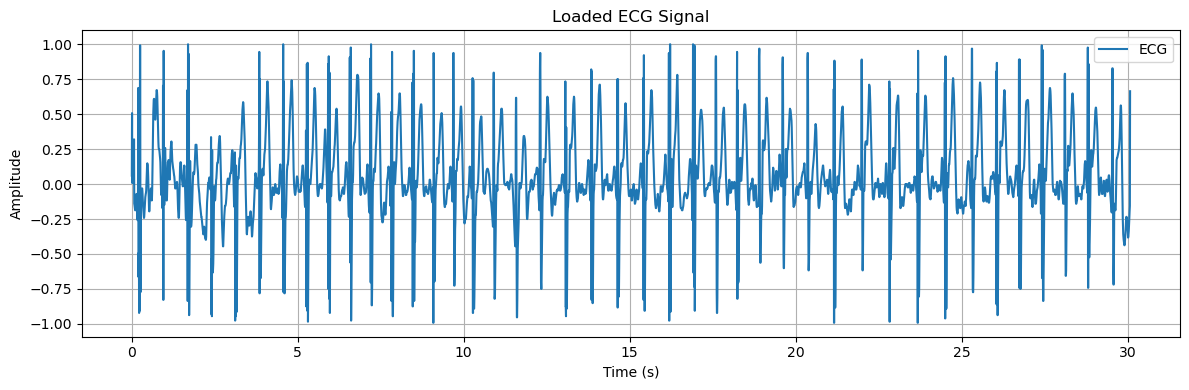

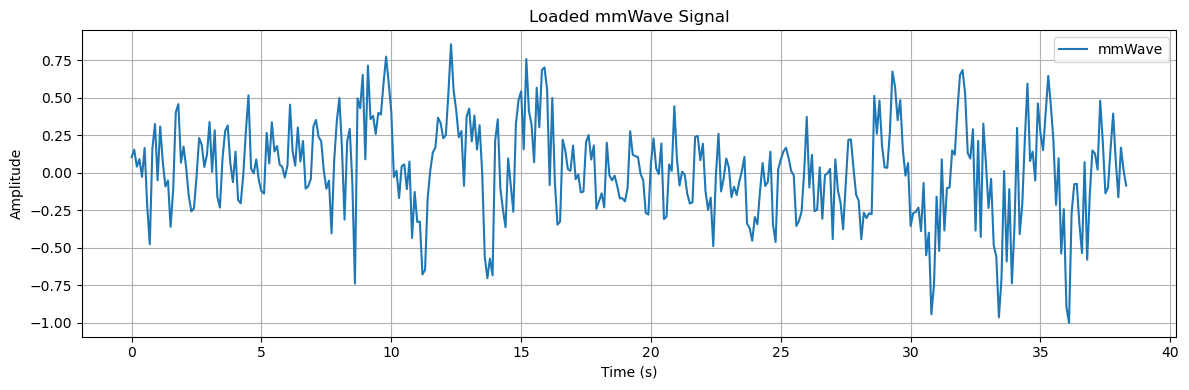

In [5]:
for i in all_sample_wave:
    print(i['path'])
    print(f'size of ecg: {len(i["ecg"])}, size of mmv: {len(i["mmv"])}')
    pltot_fixed(i['ecg'], title='Loaded ECG Signal', label='ECG')
    pltot_fixed(i['mmv'], title='Loaded mmWave Signal', label='mmWave')
    break

## preprocessing

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import savgol_filter, stft, istft, iirnotch, butter, filtfilt
from scipy.signal import hilbert

# ===== 公用工具（中文註解）=====
def bandpass(sig, fs, lo=0.8, hi=3.0, order=4): # 帶通濾波：心跳頻段 (0.8–3.0 Hz)
    # 帶通濾波：心跳頻段 (0.8–3.0 Hz)
    ny = 0.5*fs
    b, a = butter(order, [lo/ny, hi/ny], btype='band')
    return filtfilt(b, a, sig)

def notch_at(sig, fs, f0, Q=30): # 陷波：抑制呼吸基頻與其諧波
    # 陷波：抑制呼吸基頻與其諧波
    if f0 <= 0 or f0 >= fs/2:
        return sig
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, sig)

def peak_hr_bpm(x, fs, lo=0.8, hi=3.0):  # 頻域主峰估 HR（粗略）
    # 頻域主峰估 HR（粗略）
    n = len(x)
    f = np.fft.rfftfreq(n, 1/fs)
    X = np.abs(np.fft.rfft(x))
    band = (f>=lo) & (f<=hi)
    if not np.any(band):
        return np.nan
    idx = np.argmax(X[band])
    f_pk = f[band][idx]
    return f_pk*60.0

def agc_rms(x, fs, target_rms=0.6, attack_ms=30, release_ms=200, eps=1e-12):
    # 自動增益控制：讓振幅看起來一致（可選）
    a = np.exp(-1.0/(fs*attack_ms/1000.0))
    r = np.exp(-1.0/(fs*release_ms/1000.0))
    y = np.zeros_like(x, dtype=float)
    env = 0.0
    for i, xi in enumerate(x):
        e2 = xi*xi
        if e2 > env:
            env = a*env + (1-a)*e2
        else:
            env = r*env + (1-r)*e2
        g = target_rms/(np.sqrt(env)+eps)
        y[i] = xi*g
    return y

def envelope_norm(x, q=0.8, eps=1e-12):
    # 以 Hilbert 包絡做分位數正規化（可選，避免尖峰主導）
    env = np.abs(hilbert(x))
    scale = np.quantile(env, q)+eps
    return x/scale

def plot_triplet(t, x_raw, x_filt, title, overlay_alpha=0.9, ylims=None):
    # 三聯圖：Raw / Filtered / Overlay（全英文抬頭）
    fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharex=True)
    axes[0].plot(t, x_raw, linewidth=1)
    axes[0].set_title("Raw")
    axes[1].plot(t, x_filt, linewidth=1)
    axes[1].set_title("Filtered")
    axes[2].plot(t, x_raw, linewidth=1, label="Raw")
    axes[2].plot(t, x_filt, linewidth=1, alpha=overlay_alpha, label="Filtered")
    axes[2].set_title("Overlay"); axes[2].legend(loc="upper right")
    for ax in axes:
        ax.grid(True, alpha=0.3)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude")
        if ylims is not None:
            ax.set_ylim(ylims)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# ===== 方法實作（中文註解）=====
def method_bandpass(x, fs):
    # 基礎帶通
    return bandpass(x, fs, 0.8, 3.0)

def method_bp_notch(x, fs, rr_bpm):
    # 帶通 + 在呼吸與二次諧波處陷波
    y = bandpass(x, fs, 0.8, 3.0)
    rr_hz = rr_bpm/60.0
    y = notch_at(y, fs, rr_hz, Q=35)
    y = notch_at(y, fs, 2*rr_hz, Q=35)
    return y

def method_sg_bp(x, fs, win_sec=0.5, poly=3):
    # Savitzky–Golay 平滑 + 帶通
    win = int(max(5, np.floor(win_sec*fs)//2*2+1))  # 強制奇數
    y = savgol_filter(x, window_length=win, polyorder=poly, mode='interp')
    y = bandpass(y, fs, 0.8, 3.0)
    return y

def method_ssa_band_select(x, fs, embed=200, rank_max=12, lo=0.8, hi=3.0):
    # SSA：Hankel->SVD->重建前r成分->只保留主頻落在心跳帶的成分
    N = len(x)
    L = int(min(embed, N//2))
    K = N - L + 1
    X = np.column_stack([x[i:i+L] for i in range(K)])
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    r = min(rank_max, len(s))
    comps = []
    for i in range(r):
        Hi = np.outer(U[:, i]*s[i], Vt[i, :])
        y = np.zeros(N); cnt = np.zeros(N)
        for d in range(-L+1, K):
            diag_vals = np.diag(Hi, k=d)
            idxs = np.arange(max(0, -d), min(L, K-d)) + max(0, d)
            y[idxs] += diag_vals; cnt[idxs] += 1
        comps.append(y/(cnt+1e-12))
    sel = np.zeros(N)
    for y in comps:
        hr = peak_hr_bpm(y, fs, lo, hi)
        if np.isfinite(hr):
            sel += y
    return bandpass(sel, fs, lo, hi)

def method_specsub_bp(x, fs, nperseg=None, noverlap=None, alpha=1.0, floor=0.1):
    # 動態設定：對低取樣率/短序列更穩
    N = len(x)
    if nperseg is None:
        nperseg = max(32, min(256, int(round(4*fs))))  # ≈4秒窗，上限256
    nperseg = int(min(nperseg, N)) if N > 0 else 32
    if noverlap is None:
        noverlap = int(0.75 * nperseg)
    noverlap = max(0, min(noverlap, nperseg - 1))

    # STFT（允許補零），避免邊界裁切
    f, t, Z = stft(x, fs=fs, nperseg=nperseg, noverlap=noverlap,
                   boundary='zeros')  # ← 重點

    mag = np.abs(Z); ph = np.angle(Z)
    noise = np.median(mag, axis=1, keepdims=True)
    mag_hat = np.maximum(mag - alpha*noise, floor*noise)
    Z_hat = mag_hat * np.exp(1j*ph)

    # ISTFT 用同參數還原（同樣允許補零）
    _, y = istft(Z_hat, fs=fs, nperseg=nperseg, noverlap=noverlap,
                 boundary='zeros')    # ← 重點
    y = y[:N]  # 對齊原長度
    return bandpass(y, fs, 0.8, 3.0)

def method_ale(x, fs, D=6, M=14, mu=0.01):
    # 自適應線性增強器（LMS）
    N = len(x); w = np.zeros(M); y = np.zeros(N)
    ref = np.zeros(N); ref[D:] = x[:-D]
    for n in range(M, N):
        u = ref[n-M:n][::-1]
        y[n] = np.dot(w, u)
        e = x[n] - y[n]
        w += 2*mu*e*u
    return bandpass(y, fs, 0.8, 3.0)

# ===== Kalman 濾波（中文註解）=====
def kalman_1d(x, q_scale=1e-4, r_scale=1e-2, smooth=True):
    """
    一維卡爾曼：狀態 x_k = x_{k-1} + w_k，量測 z_k = x_k + v_k
    Q = q_scale*var(x), R = r_scale*var(x)
    smooth=True 時回傳 RTS 平滑結果，否則回傳前向濾波
    """
    x = np.asarray(x, dtype=float)
    N = len(x)
    if N == 0:
        return x

    var = np.var(x) + 1e-12
    Q = q_scale * var
    R = r_scale * var

    # 前向濾波
    x_pred = np.zeros(N)
    P_pred = np.zeros(N)
    x_filt = np.zeros(N)
    P_filt = np.zeros(N)

    # 初始化
    x_filt[0] = x[0]
    P_filt[0] = var

    for k in range(1, N):
        # predict
        x_pred[k] = x_filt[k-1]
        P_pred[k] = P_filt[k-1] + Q
        # update
        K = P_pred[k] / (P_pred[k] + R)
        x_filt[k] = x_pred[k] + K * (x[k] - x_pred[k])
        P_filt[k] = (1 - K) * P_pred[k]

    if not smooth:
        return x_filt

    # RTS 平滑
    x_smooth = np.copy(x_filt)
    P_smooth = np.copy(P_filt)
    for k in range(N-2, -1, -1):
        C = P_filt[k] / (P_pred[k+1] + 1e-12)
        x_smooth[k] = x_filt[k] + C * (x_smooth[k+1] - x_pred[k+1])
        P_smooth[k] = P_filt[k] + C**2 * (P_smooth[k+1] - P_pred[k+1])
    return x_smooth

def method_kalman_then_bp(x, fs, q_scale=1e-4, r_scale=1e-2, smooth=True):
    # 先卡爾曼平滑原始訊號，再帶通到心跳帶
    xd = signal.detrend(x, type="linear")
    xk = kalman_1d(xd, q_scale=q_scale, r_scale=r_scale, smooth=smooth)
    return bandpass(xk, fs, 0.8, 3.0)

def method_bp_then_kalman(x, fs, q_scale=5e-5, r_scale=5e-3, smooth=True):
    # 先帶通聚焦心跳，再用卡爾曼去除殘餘雜訊與波紋
    y = bandpass(x, fs, 0.8, 3.0)
    yk = kalman_1d(y, q_scale=q_scale, r_scale=r_scale, smooth=smooth)
    return yk

# ===== 取資料 =====
# 假設你已建立 summary（含 dataframe: t_sec/heartbeat, fs_Hz）



In [7]:
import re
import numpy as np
import pandas as pd

# 依你前面定義的方法與參數
# Methods list (display_name, function, kwargs)
methods = [
    ("Baseline Bandpass",              method_bandpass,        dict()),
    ("BP + Notch @ rr & 2rr",          method_bp_notch,        dict(rr_bpm=14.0)),  # set rr_bpm_for_notch
    ("Savitzky–Golay + BP",            method_sg_bp,           dict(win_sec=0.5, poly=3)),
    ("SSA Band-Selected + BP",         method_ssa_band_select, dict(embed=200, rank_max=12, lo=0.8, hi=3.0)),
    ("STFT Spectral Subtraction + BP", method_specsub_bp,      dict(nperseg=256, noverlap=192, alpha=1.0, floor=0.1)),
    ("ALE Adaptive Enhancer + BP",     method_ale,             dict(D=6, M=14, mu=0.01)),
    ("Kalman → Bandpass",              method_kalman_then_bp,  dict(q_scale=1e-4, r_scale=1e-2, smooth=True)),
    ("Bandpass → Kalman",              method_bp_then_kalman,  dict(q_scale=5e-5, r_scale=5e-3, smooth=True)),
]
# 可選旗標：use_agc, use_env_norm, rr_bpm_for_notch 已在你上方定義

def _fs_from_t(t):
    dt = np.nanmedian(np.diff(t)) if len(t) > 1 else np.nan
    return float(1.0/dt) if np.isfinite(dt) and dt > 0 else 10.0

def _sanitize_key(name):
    key = name.lower()
    key = re.sub(r'[^a-z0-9]+', '_', key).strip('_')
    return key

def build_preprocessing(all_sample_wave, methods):
    for it in all_sample_wave:
        df_mmv = it["mmv"]         # expects columns: t_sec, wave
        t = df_mmv["t_sec"].to_numpy(float)
        x = df_mmv["wave"].to_numpy(float)
        fs = _fs_from_t(t)

        x_in = x.copy()
        if 'use_agc' in globals() and use_agc:
            x_in = agc_rms(x_in, fs)
        if 'use_env_norm' in globals() and use_env_norm:
            x_in = envelope_norm(x_in, q=0.8)

        pre = {}
        for disp_name, func, kwargs in methods:
            key = _sanitize_key(disp_name)
            y = func(x_in, fs, **kwargs)
            pre[key] = pd.DataFrame({"t_sec": t, "wave": y})

        it["pre_processing"] = pre

# 執行
build_preprocessing(all_sample_wave, methods)

# 使用示例：
all_sample_wave[0]["pre_processing"].keys()  # 查看有哪些預處理方法

dict_keys(['baseline_bandpass', 'bp_notch_rr_2rr', 'savitzky_golay_bp', 'ssa_band_selected_bp', 'stft_spectral_subtraction_bp', 'ale_adaptive_enhancer_bp', 'kalman_bandpass', 'bandpass_kalman'])

In [9]:
import numpy as np
import pandas as pd

for num in all_sample_wave:
    pre = num.get('pre_processing', {})
    if not pre:
        continue

    num.setdefault('preproc_wave', {})  # 只存處理後的波形
    for mkey, df_pp in pre.items():
        # 僅保留 t_sec、wave，原樣放入
        df_pp2 = pd.DataFrame({
            "t_sec": pd.to_numeric(df_pp["t_sec"], errors="coerce"),
            "wave":  pd.to_numeric(df_pp["wave"],  errors="coerce"),
        }).dropna(subset=["t_sec","wave"]).reset_index(drop=True)

        num['preproc_wave'][mkey] = df_pp2

    print(num['path'], "methods stored:", list(num['preproc_wave'].keys()))

/Users/hsiangyu/Documents/radar-heartbeat-detection/實驗區/data/sample_0 methods stored: ['baseline_bandpass', 'bp_notch_rr_2rr', 'savitzky_golay_bp', 'ssa_band_selected_bp', 'stft_spectral_subtraction_bp', 'ale_adaptive_enhancer_bp', 'kalman_bandpass', 'bandpass_kalman']
/Users/hsiangyu/Documents/radar-heartbeat-detection/實驗區/data/sample_1 methods stored: ['baseline_bandpass', 'bp_notch_rr_2rr', 'savitzky_golay_bp', 'ssa_band_selected_bp', 'stft_spectral_subtraction_bp', 'ale_adaptive_enhancer_bp', 'kalman_bandpass', 'bandpass_kalman']
/Users/hsiangyu/Documents/radar-heartbeat-detection/實驗區/data/sample_2 methods stored: ['baseline_bandpass', 'bp_notch_rr_2rr', 'savitzky_golay_bp', 'ssa_band_selected_bp', 'stft_spectral_subtraction_bp', 'ale_adaptive_enhancer_bp', 'kalman_bandpass', 'bandpass_kalman']
/Users/hsiangyu/Documents/radar-heartbeat-detection/實驗區/data/sample_3 methods stored: ['baseline_bandpass', 'bp_notch_rr_2rr', 'savitzky_golay_bp', 'ssa_band_selected_bp', 'stft_spectral_sub

In [10]:
import numpy as np, pandas as pd, os

# --- helpers ---
def _infer_fs_from_t(t, fallback=10.0):
    t = np.asarray(t, float)
    if t.size > 1:
        dt = np.nanmedian(np.diff(t))
        if np.isfinite(dt) and dt > 0:
            return float(1.0/dt)
    return float(fallback)

def _hr_fft_peak_bpm(y, fs, lo=0.8, hi=3.0):
    y = np.asarray(y, float)
    n = len(y)
    if n < 16 or fs <= 0:
        return np.nan
    w = np.hanning(n)
    Y = np.fft.rfft((y - np.nanmean(y)) * w)
    f = np.fft.rfftfreq(n, 1.0/fs)
    band = (f >= lo) & (f <= hi)
    if not np.any(band):
        return np.nan
    idx = np.nanargmax(np.abs(Y[band]))
    f_pk = f[band][idx]
    return float(f_pk * 60.0)

# --- build long table: sample × method ---
rows = []
for it in all_sample_wave:
    sample = os.path.basename(str(it.get("path","")))
    gt_hr = float(it.get("ecg_hr_res", np.nan))
    pre = it.get("preproc_wave", {}) or {}
    for mkey, dfw in pre.items():
        t = dfw["t_sec"].to_numpy(float)
        x = dfw["wave"].to_numpy(float)
        fs = _infer_fs_from_t(t, fallback=10.0)
        est = _hr_fft_peak_bpm(x, fs, lo=0.8, hi=3.0)
        rows.append({
            "sample": sample,
            "method": mkey,
            "ECG_HR_bpm": gt_hr,
            "Est_HR_bpm": est,
            "Diff_bpm": est - gt_hr if np.isfinite(est) and np.isfinite(gt_hr) else np.nan,
            "AbsErr_bpm": abs(est - gt_hr) if np.isfinite(est) and np.isfinite(gt_hr) else np.nan,
        })

df_long = pd.DataFrame(rows).sort_values(["method","sample"]).reset_index(drop=True)
print(df_long.head())

# --- per-method summary across all samples (累加/平均) ---
method_sum = (
    df_long.groupby("method", as_index=False)
      .agg(
          N=("sample","count"),
          MAE_bpm=("AbsErr_bpm","mean"),
          MdAE_bpm=("AbsErr_bpm","median"),
          RMSE_bpm=("Diff_bpm", lambda s: float(np.sqrt(np.nanmean((s.values)**2)))),
          Bias_bpm=("Diff_bpm","mean"),
          TotalAbsErr_bpm=("AbsErr_bpm","sum")
      )
      .sort_values(["MAE_bpm","RMSE_bpm","TotalAbsErr_bpm"], ascending=[True, True, True])
)
print(method_sum)

# 儲存
df_long.to_csv("hr_eval_rhythmwave_long.csv", index=False)
method_sum.to_csv("hr_eval_rhythmwave_method_summary.csv", index=False)

     sample                    method  ECG_HR_bpm  Est_HR_bpm   Diff_bpm  \
0  sample_0  ale_adaptive_enhancer_bp   81.131846   70.312500 -10.819346   
1  sample_1  ale_adaptive_enhancer_bp   78.625101  100.000000  21.374899   
2  sample_2  ale_adaptive_enhancer_bp   80.372010   68.333333 -12.038676   
3  sample_3  ale_adaptive_enhancer_bp   86.883846   85.384615  -1.499231   
4  sample_4  ale_adaptive_enhancer_bp  131.928451  131.351351  -0.577100   

   AbsErr_bpm  
0   10.819346  
1   21.374899  
2   12.038676  
3    1.499231  
4    0.577100  
                         method  N    MAE_bpm   MdAE_bpm   RMSE_bpm  \
2             baseline_bandpass  6   9.814696  11.429011  12.219832   
3               bp_notch_rr_2rr  6   9.814696  11.429011  12.219832   
5             savitzky_golay_bp  6   9.814696  11.429011  12.219832   
7  stft_spectral_subtraction_bp  6  17.860859  11.429011  27.156631   
0      ale_adaptive_enhancer_bp  6  20.619480  11.429011  33.449952   
1               bandp